# **Importing torchvision For Carbon Emission**

In [ ]:
!pip install -q torch torchvision codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.7/516.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy
import pandas as pd

# **Dataset Visualization and Inference**

100%|██████████| 170M/170M [00:03<00:00, 50.3MB/s]


Sample Training Images:


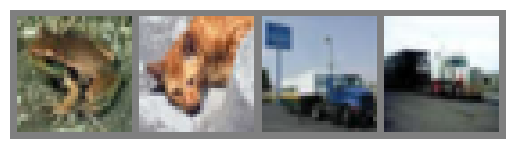

Class Labels: frog | cat | truck | truck


In [ ]:
# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

classes = trainset.classes

# Helper function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy().transpose((1, 2, 0))  # Convert to H x W x C
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and their labels
print("Sample Training Images:")
imshow(torchvision.utils.make_grid(images))
print('Class Labels:', ' | '.join([classes[label] for label in labels]))

# **Data Cleaning**

Total training samples: 50000
Total test samples: 10000
Shape of one image: torch.Size([3, 32, 32])
Label (class index) of each sample in batch: tensor([6, 3, 9, 9])
Corrupted image samples found: 0


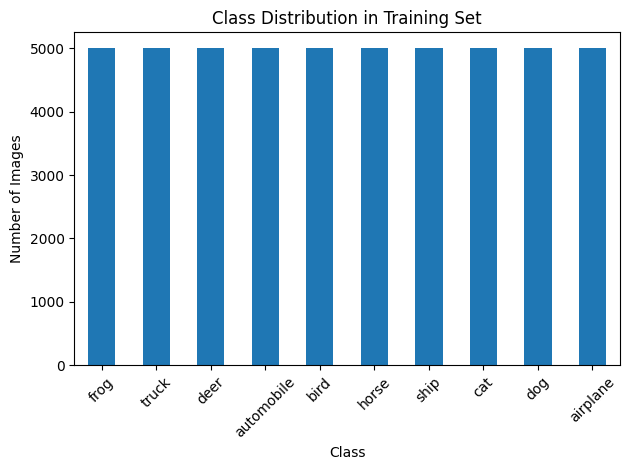

In [ ]:
# Check dataset size
print(f"Total training samples: {len(trainset)}")
print(f"Total test samples: {len(torchvision.datasets.CIFAR10(root='./data', train=False))}")

# Check one batch shape and label range
print("Shape of one image:", images[0].shape)
print("Label (class index) of each sample in batch:", labels)

# Check for corrupted or blank images (rare in CIFAR-10, but good practice)
corrupt_count = 0
for img, label in trainset:
    if not isinstance(img, torch.Tensor) or img.numel() == 0:
        corrupt_count += 1

print(f"Corrupted image samples found: {corrupt_count}")

# Check label distribution (class balance)
from collections import Counter
label_counts = Counter()
for _, label in trainset:
    label_counts[label] += 1

# Display label distribution
label_names = [classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

df = pd.DataFrame({'Class': label_names, 'Count': counts})
df.plot(kind='bar', x='Class', y='Count', legend=False, title="Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data Preprocessing Steps**

Sample batch after preprocessing (augmented):


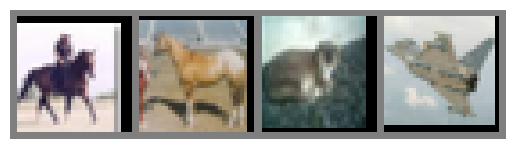

Class Labels: horse | horse | cat | airplane


In [ ]:
# Define preprocessing pipeline with optional augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomCrop(32, padding=4),    # Augmentation
    transforms.ToTensor(),                   # Convert to tensor [0,1]
    transforms.Normalize((0.5, 0.5, 0.5),     # Normalize to [-1, 1]
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# Reload dataset with preprocessing transforms
trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset_augmented, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Preview one augmented batch
dataiter = iter(trainloader)
images_aug, labels_aug = next(dataiter)

print("Sample batch after preprocessing (augmented):")
imshow(torchvision.utils.make_grid(images_aug[:4]))
print("Class Labels:", ' | '.join([classes[label] for label in labels_aug[:4]]))

# **Feature Scaling / Normalization**

In [ ]:
# Confirm the normalization transformation applied
print("Transform used for normalization:")
print(transform_train.transforms[-1])  # Print the Normalize transform

# Check range of pixel values after normalization
sample_img = images_aug[0]
print("Pixel value range after normalization:")
print("Min:", sample_img.min().item())
print("Max:", sample_img.max().item())

Transform used for normalization:
Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
Pixel value range after normalization:
Min: -1.0
Max: 1.0


# **Model Evaluation**

In [ ]:
# Global result tracker for models
model_results = []

**Convolutional Neural Network**

[codecarbon INFO @ 12:46:29] [setup] RAM Tracking...
[codecarbon INFO @ 12:46:29] [setup] CPU Tracking...
[codecarbon WARNING @ 12:46:29] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 12:46:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:46:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:46:30] [setup] GPU Tracking...
[codecarbon INFO @ 12:46:30] No GPU found.
[codecarbon INFO @ 12:46:30] >>> Tracker's metadata:
[codecarbon INFO @ 12:46:30]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 12:46:30]   Python version: 3.11.12
[codecarbon INFO @ 12:46:30]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 12:46:30]   Available RAM : 12.675 GB
[codecarbon INFO @ 12:46:30]   CPU count: 2
[codecarbon INFO @ 12:46

[Epoch 1, Batch 100] loss: 1.914


[codecarbon INFO @ 12:47:00] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:47:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:00] 0.000394 kWh of electricity used since the beginning.


[Epoch 1, Batch 200] loss: 1.635


[codecarbon INFO @ 12:47:15] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:47:15] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:15] 0.000591 kWh of electricity used since the beginning.


[Epoch 1, Batch 300] loss: 1.526


[codecarbon INFO @ 12:47:30] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:47:30] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:30] 0.000788 kWh of electricity used since the beginning.


[Epoch 1, Batch 400] loss: 1.413


[codecarbon INFO @ 12:47:45] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:47:45] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:47:45] 0.000985 kWh of electricity used since the beginning.


[Epoch 1, Batch 500] loss: 1.414


[codecarbon INFO @ 12:48:00] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:48:00] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:00] 0.001181 kWh of electricity used since the beginning.


[Epoch 1, Batch 600] loss: 1.326


[codecarbon INFO @ 12:48:15] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:48:15] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:15] 0.001378 kWh of electricity used since the beginning.


[Epoch 1, Batch 700] loss: 1.291


[codecarbon INFO @ 12:48:30] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:48:30] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:30] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:48:30] 0.003746 g.CO2eq/s mean an estimation of 118.14585257161521 kg.CO2eq/year
[codecarbon INFO @ 12:48:45] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:48:45] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:48:45] 0.001772 kWh of electricity used since the beginning.


[Epoch 2, Batch 100] loss: 1.232


[codecarbon INFO @ 12:49:00] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:49:00] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:00] 0.001969 kWh of electricity used since the beginning.


[Epoch 2, Batch 200] loss: 1.188


[codecarbon INFO @ 12:49:15] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:49:15] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:15] 0.002166 kWh of electricity used since the beginning.


[Epoch 2, Batch 300] loss: 1.164


[codecarbon INFO @ 12:49:30] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:49:30] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:30] 0.002363 kWh of electricity used since the beginning.


[Epoch 2, Batch 400] loss: 1.129


[codecarbon INFO @ 12:49:45] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:49:45] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:49:45] 0.002560 kWh of electricity used since the beginning.


[Epoch 2, Batch 500] loss: 1.118


[codecarbon INFO @ 12:50:00] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:50:00] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:00] 0.002757 kWh of electricity used since the beginning.


[Epoch 2, Batch 600] loss: 1.082


[codecarbon INFO @ 12:50:15] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:50:15] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:15] 0.002953 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:30] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:50:30] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:30] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:50:30] 0.003746 g.CO2eq/s mean an estimation of 118.14069259432966 kg.CO2eq/year


[Epoch 2, Batch 700] loss: 1.068


[codecarbon INFO @ 12:50:45] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:50:45] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:50:45] 0.003347 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:51:00] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:51:00] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:00] 0.003544 kWh of electricity used since the beginning.


[Epoch 3, Batch 100] loss: 1.028


[codecarbon INFO @ 12:51:15] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:51:15] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:15] 0.003741 kWh of electricity used since the beginning.


[Epoch 3, Batch 200] loss: 1.036


[codecarbon INFO @ 12:51:30] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:51:30] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:30] 0.003938 kWh of electricity used since the beginning.


[Epoch 3, Batch 300] loss: 1.005


[codecarbon INFO @ 12:51:45] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:51:45] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:51:45] 0.004135 kWh of electricity used since the beginning.


[Epoch 3, Batch 400] loss: 0.986


[codecarbon INFO @ 12:52:00] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:52:00] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:00] 0.004332 kWh of electricity used since the beginning.


[Epoch 3, Batch 500] loss: 0.964


[codecarbon INFO @ 12:52:15] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:52:15] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:15] 0.004529 kWh of electricity used since the beginning.


[Epoch 3, Batch 600] loss: 0.946


[codecarbon INFO @ 12:52:30] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:52:30] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:30] 0.004725 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:52:30] 0.003746 g.CO2eq/s mean an estimation of 118.13971808919042 kg.CO2eq/year


[Epoch 3, Batch 700] loss: 0.954


[codecarbon INFO @ 12:52:45] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:52:45] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:52:45] 0.004922 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:00] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:53:00] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:00] 0.005119 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:53:15] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:53:15] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:15] 0.005316 kWh of electricity used since the beginning.


[Epoch 4, Batch 100] loss: 0.938


[codecarbon INFO @ 12:53:30] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:53:30] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:30] 0.005513 kWh of electricity used since the beginning.


[Epoch 4, Batch 200] loss: 0.898


[codecarbon INFO @ 12:53:45] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:53:45] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:53:45] 0.005710 kWh of electricity used since the beginning.


[Epoch 4, Batch 300] loss: 0.903


[codecarbon INFO @ 12:54:00] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:54:00] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:00] 0.005907 kWh of electricity used since the beginning.


[Epoch 4, Batch 400] loss: 0.912


[codecarbon INFO @ 12:54:15] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:54:15] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:15] 0.006103 kWh of electricity used since the beginning.


[Epoch 4, Batch 500] loss: 0.888


[codecarbon INFO @ 12:54:30] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:54:30] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:30] 0.006300 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:54:30] 0.003746 g.CO2eq/s mean an estimation of 118.1380344790071 kg.CO2eq/year


[Epoch 4, Batch 600] loss: 0.899


[codecarbon INFO @ 12:54:45] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:54:45] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:54:45] 0.006497 kWh of electricity used since the beginning.


[Epoch 4, Batch 700] loss: 0.874


[codecarbon INFO @ 12:55:00] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:55:00] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:00] 0.006694 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:15] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:55:15] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:15] 0.006891 kWh of electricity used since the beginning.


[Epoch 5, Batch 100] loss: 0.853


[codecarbon INFO @ 12:55:30] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:55:30] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:30] 0.007088 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:55:45] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:55:45] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:45] 0.007284 kWh of electricity used since the beginning.


[Epoch 5, Batch 200] loss: 0.850


[codecarbon INFO @ 12:56:00] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:56:00] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:00] 0.007481 kWh of electricity used since the beginning.


[Epoch 5, Batch 300] loss: 0.848


[codecarbon INFO @ 12:56:15] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:56:15] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:15] 0.007678 kWh of electricity used since the beginning.


[Epoch 5, Batch 400] loss: 0.820


[codecarbon INFO @ 12:56:30] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:56:30] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:30] 0.007875 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:56:30] 0.003746 g.CO2eq/s mean an estimation of 118.12286046320834 kg.CO2eq/year


[Epoch 5, Batch 500] loss: 0.848


[codecarbon INFO @ 12:56:45] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:56:45] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:45] 0.008072 kWh of electricity used since the beginning.


[Epoch 5, Batch 600] loss: 0.825


[codecarbon INFO @ 12:57:00] Energy consumed for RAM : 0.000832 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:57:00] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:00] 0.008269 kWh of electricity used since the beginning.


[Epoch 5, Batch 700] loss: 0.845


[codecarbon INFO @ 12:57:15] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:57:15] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:15] 0.008465 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:57:27] Energy consumed for RAM : 0.000867 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:57:27] Energy consumed for all CPUs : 0.007753 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:57:27] 0.008620 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.va

Estimated CO₂ emissions: 0.0025 kg
Test Accuracy: 72.22%


<Figure size 1000x800 with 0 Axes>

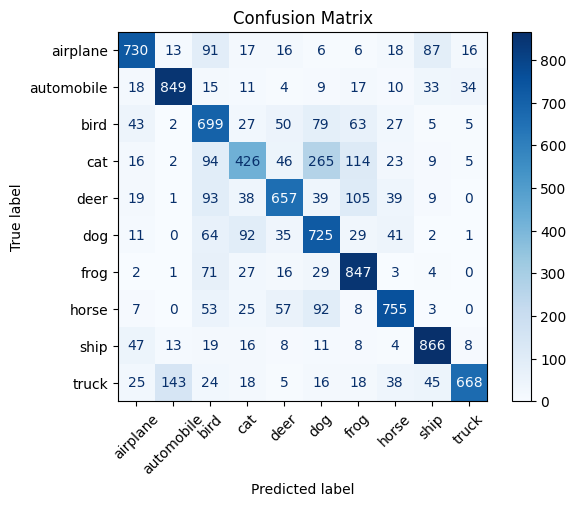

In [ ]:
# Define CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Track emissions
tracker = EmissionsTracker(project_name="cnn_cifar10")
tracker.start()

# Train the CNN
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

# Stop emissions tracker
emissions = tracker.stop()
print(f"Estimated CO₂ emissions: {emissions:.4f} kg")

# Evaluate model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Accuracy= 100 * correct / total
print(f"Test Accuracy: {Accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (Federated): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (Federated): {Accuracy:.2f}%\033[0m")

Estimated CO₂ emissions: 0.0029 kg
Test Accuracy: 71.39%


In [ ]:
model_results.append({
    "Model": "CNN",
    "Accuracy": Accuracy,
    "CO2 (kg)": emissions if emissions is not None else 0
})

**CNN + Federated**

[codecarbon INFO @ 12:58:06] [setup] RAM Tracking...
[codecarbon INFO @ 12:58:06] [setup] CPU Tracking...
[codecarbon WARNING @ 12:58:06] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 12:58:08] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 12:58:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 12:58:08] [setup] GPU Tracking...
[codecarbon INFO @ 12:58:08] No GPU found.
[codecarbon INFO @ 12:58:08] >>> Tracker's metadata:
[codecarbon INFO @ 12:58:08]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 12:58:08]   Python version: 3.11.12
[codecarbon INFO @ 12:58:08]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 12:58:08]   Available RAM : 12.675 GB
[codecarbon INFO @ 12:58:08]   CPU count: 2
[codecarbon INFO @ 12:58

Federated Round 1/5
Client 1 training...


[codecarbon INFO @ 12:58:23] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:58:23] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:23] 0.000197 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 12:58:38] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:58:38] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:38] 0.000394 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:58:53] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:58:53] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:58:53] 0.000591 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 12:59:08] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:59:08] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:08] 0.000787 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 12:59:23] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:59:23] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:23] 0.000984 kWh of electricity used since the beginning.
[codecarbon INFO @ 12:59:38] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:59:38] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:38] 0.001181 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 12:59:53] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 12:59:53] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:59:53] 0.001378 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:08] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:00:08] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:08] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:08] 0.003746 g.CO2eq/s mean an estimation of 118.14650112129378 kg.CO2eq/year


Federated Round 2/5
Client 1 training...


[codecarbon INFO @ 13:00:23] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:00:23] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:23] 0.001772 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 13:00:38] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:00:38] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:38] 0.001969 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:00:53] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:00:53] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:00:53] 0.002166 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 13:01:08] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:01:08] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:08] 0.002362 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:23] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:01:23] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:23] 0.002559 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 13:01:38] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:01:38] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:38] 0.002756 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:01:53] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:01:53] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:01:53] 0.002953 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 13:02:08] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:02:08] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:08] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:08] 0.003746 g.CO2eq/s mean an estimation of 118.13103602901334 kg.CO2eq/year


Federated Round 3/5
Client 1 training...


[codecarbon INFO @ 13:02:23] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:02:23] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:23] 0.003347 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:02:38] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:02:38] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:38] 0.003544 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 13:02:53] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:02:53] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:02:53] 0.003740 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:08] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:03:08] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:08] 0.003937 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 13:03:23] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:03:23] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:23] 0.004134 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 13:03:38] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:03:38] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:38] 0.004331 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:03:53] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:03:53] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:03:53] 0.004528 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 13:04:08] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:04:08] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:08] 0.004725 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:04:08] 0.003746 g.CO2eq/s mean an estimation of 118.13724133649238 kg.CO2eq/year


Federated Round 4/5
Client 1 training...


[codecarbon INFO @ 13:04:23] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:04:23] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:23] 0.004922 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:04:38] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:04:38] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:38] 0.005118 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 13:04:53] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:04:53] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:04:53] 0.005315 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:08] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:05:08] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:08] 0.005512 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 13:05:23] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:05:23] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:23] 0.005709 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 13:05:38] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:05:38] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:38] 0.005906 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:05:53] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:05:53] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:05:53] 0.006102 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 13:06:08] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:06:08] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:08] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:06:08] 0.003746 g.CO2eq/s mean an estimation of 118.12320008058715 kg.CO2eq/year
[codecarbon INFO @ 13:06:23] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:06:23] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:23] 0.006496 kWh of electricity used since the beginning.


Federated Round 5/5
Client 1 training...


[codecarbon INFO @ 13:06:38] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:06:38] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:38] 0.006693 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 13:06:53] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:06:53] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:06:53] 0.006890 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:08] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:07:08] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:08] 0.007086 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 13:07:23] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:07:23] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:23] 0.007283 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:07:38] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:07:38] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:38] 0.007480 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 13:07:53] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:07:53] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:07:53] 0.007677 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 13:08:08] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:08:08] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:08:08] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:08] 0.003746 g.CO2eq/s mean an estimation of 118.13692937087644 kg.CO2eq/year
[codecarbon INFO @ 13:08:23] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:08:23] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:08:23] 0.008071 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:08:29] Energy consumed for RAM : 0.000820 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:08:29] Energy consumed for all CPUs : 0.007333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:08:29] 0.008153 kWh of electricity used since the beginning.


Estimated CO₂ emissions (Federated): 0.0023 kg
Test Accuracy (Federated): 61.44%


<Figure size 1000x800 with 0 Axes>

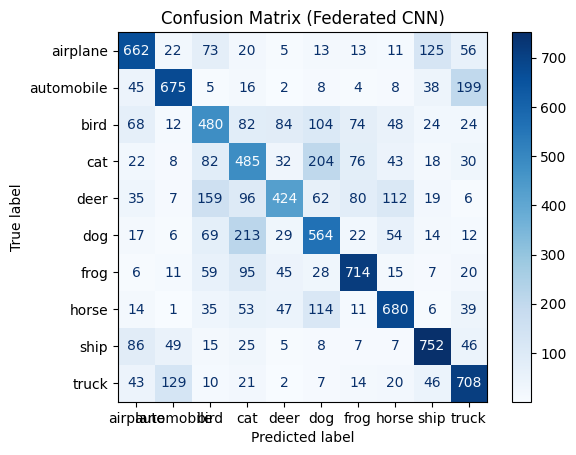

In [ ]:
# Split dataset for 5 clients
num_clients = 5
client_datasets = random_split(trainset_augmented, [len(trainset_augmented) // num_clients] * num_clients)
client_loaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in client_datasets]

# Define CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Local training function
def train_local_model(model, loader, epochs=1):
    model = copy.deepcopy(model).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

# Federated averaging function
def fed_avg(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for key in avg:
        for i in range(1, len(state_dicts)):
            avg[key] += state_dicts[i][key]
        avg[key] /= len(state_dicts)
    return avg

# Initialize global model
global_model = Net().to(device)
tracker = EmissionsTracker(project_name="cnn_federated")
tracker.start()

# Federated training loop
for r in range(5):
    print(f"Federated Round {r+1}/5")
    local_weights = []
    for i, loader in enumerate(client_loaders):
        print(f"Client {i+1} training...")
        weights = train_local_model(global_model, loader)
        local_weights.append(weights)
    global_model.load_state_dict(fed_avg(local_weights))

# Stop emissions tracker and safely store result
emissions = tracker.stop()
if emissions is not None:
    print(f"\033[1mEstimated CO₂ emissions (Federated): {emissions:.4f} kg\033[0m")
else:
    emissions = 0
    print("\033[1mEstimated CO₂ emissions: Not available\033[0m")

# Evaluate global model
global_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = global_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\033[1mTest Accuracy (Federated): {accuracy:.2f}%\033[0m")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Federated CNN)")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (Federated): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (Federated): {accuracy:.2f}%\033[0m")

In [ ]:
# Save model result for comparison chart
model_results.append({
    "Model": "CNN + Federated",
    "Accuracy": accuracy,
    "CO2 (kg)": emissions})

**CNN + Attention**

[codecarbon INFO @ 13:09:02] [setup] RAM Tracking...
[codecarbon INFO @ 13:09:02] [setup] CPU Tracking...
[codecarbon WARNING @ 13:09:02] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 13:09:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:09:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 13:09:03] [setup] GPU Tracking...
[codecarbon INFO @ 13:09:03] No GPU found.
[codecarbon INFO @ 13:09:03] >>> Tracker's metadata:
[codecarbon INFO @ 13:09:03]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 13:09:03]   Python version: 3.11.12
[codecarbon INFO @ 13:09:03]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 13:09:03]   Available RAM : 12.675 GB
[codecarbon INFO @ 13:09:03]   CPU count: 2
[codecarbon INFO @ 13:09

[Epoch 1, Batch 100] loss: 1.957


[codecarbon INFO @ 13:13:18] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:13:18] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:13:18] 0.003347 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:33] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:13:33] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:13:33] 0.003544 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:13:48] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:13:48] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:13:48] 0.003741 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:14:03] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:14:03] Energy consumed for a

[Epoch 1, Batch 200] loss: 1.673


[codecarbon INFO @ 13:17:33] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:17:33] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:33] 0.006694 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:17:48] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:17:48] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:17:48] 0.006891 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:18:03] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:18:03] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:18:03] 0.007088 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:18:18] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:18:18] Energy consumed for a

[Epoch 1, Batch 300] loss: 1.569


[codecarbon INFO @ 13:21:48] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:21:48] Energy consumed for all CPUs : 0.009031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:21:48] 0.010041 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:03] Energy consumed for RAM : 0.001030 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:22:03] Energy consumed for all CPUs : 0.009208 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:22:03] 0.010238 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:18] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:22:18] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:22:18] 0.010434 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:22:33] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:22:33] Energy consumed for a

[Epoch 1, Batch 400] loss: 1.471


[codecarbon INFO @ 13:26:03] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:26:03] Energy consumed for all CPUs : 0.012042 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:26:03] 0.013388 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:18] Energy consumed for RAM : 0.001366 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:26:18] Energy consumed for all CPUs : 0.012219 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:26:18] 0.013585 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:33] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:26:33] Energy consumed for all CPUs : 0.012396 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:26:33] 0.013782 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:26:48] Energy consumed for RAM : 0.001406 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:26:48] Energy consumed for a

[Epoch 1, Batch 500] loss: 1.417


[codecarbon INFO @ 13:30:03] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:30:03] Energy consumed for all CPUs : 0.014875 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:30:03] 0.016538 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:30:18] Energy consumed for RAM : 0.001683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:30:18] Energy consumed for all CPUs : 0.015052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:30:18] 0.016735 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:30:33] Energy consumed for RAM : 0.001703 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:30:33] Energy consumed for all CPUs : 0.015229 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:30:33] 0.016932 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:30:48] Energy consumed for RAM : 0.001723 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:30:48] Energy consumed for a

[Epoch 1, Batch 600] loss: 1.382


[codecarbon INFO @ 13:34:34] Energy consumed for RAM : 0.002020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:34:34] Energy consumed for all CPUs : 0.018063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:34:34] 0.020082 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:34:49] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:34:49] Energy consumed for all CPUs : 0.018240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:34:49] 0.020279 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:04] Energy consumed for RAM : 0.002059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:35:04] Energy consumed for all CPUs : 0.018417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:35:04] 0.020476 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:35:04] 0.003746 g.CO2eq/s mean an estimation of 118.12547670987232 kg.CO2eq/year
[codecarbon INFO @ 13:35:19] Energy consumed for

[Epoch 1, Batch 700] loss: 1.315


[codecarbon INFO @ 13:38:34] Energy consumed for RAM : 0.002336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:38:34] Energy consumed for all CPUs : 0.020896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:38:34] 0.023233 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:38:49] Energy consumed for RAM : 0.002356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:38:49] Energy consumed for all CPUs : 0.021073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:38:49] 0.023430 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:04] Energy consumed for RAM : 0.002376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:39:04] Energy consumed for all CPUs : 0.021250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:39:04] 0.023626 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:39:04] 0.003746 g.CO2eq/s mean an estimation of 118.13493368355908 kg.CO2eq/year
[codecarbon INFO @ 13:39:19] Energy consumed for

[Epoch 2, Batch 100] loss: 1.205


[codecarbon INFO @ 13:46:19] Energy consumed for RAM : 0.002950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:46:19] Energy consumed for all CPUs : 0.026386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:46:19] 0.029336 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:34] Energy consumed for RAM : 0.002970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:46:34] Energy consumed for all CPUs : 0.026563 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:46:34] 0.029533 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:46:49] Energy consumed for RAM : 0.002990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:46:49] Energy consumed for all CPUs : 0.026740 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:46:49] 0.029730 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:47:04] Energy consumed for RAM : 0.003010 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:47:04] Energy consumed for a

[Epoch 2, Batch 200] loss: 1.186


[codecarbon INFO @ 13:50:34] Energy consumed for RAM : 0.003287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:50:34] Energy consumed for all CPUs : 0.029396 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:50:34] 0.032683 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:50:49] Energy consumed for RAM : 0.003307 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:50:49] Energy consumed for all CPUs : 0.029573 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:50:49] 0.032880 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:04] Energy consumed for RAM : 0.003326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:51:04] Energy consumed for all CPUs : 0.029750 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:51:04] 0.033077 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:51:04] 0.003746 g.CO2eq/s mean an estimation of 118.13840547157378 kg.CO2eq/year
[codecarbon INFO @ 13:51:19] Energy consumed for

[Epoch 2, Batch 300] loss: 1.160


[codecarbon INFO @ 13:55:04] Energy consumed for RAM : 0.003643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:55:04] Energy consumed for all CPUs : 0.032583 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:55:04] 0.036226 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:04] 0.003745 g.CO2eq/s mean an estimation of 118.11529904788084 kg.CO2eq/year
[codecarbon INFO @ 13:55:19] Energy consumed for RAM : 0.003663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:55:19] Energy consumed for all CPUs : 0.032760 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:55:19] 0.036423 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:34] Energy consumed for RAM : 0.003683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:55:34] Energy consumed for all CPUs : 0.032937 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:55:34] 0.036620 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:55:49] Energy consumed for

[Epoch 2, Batch 400] loss: 1.134


[codecarbon INFO @ 13:59:19] Energy consumed for RAM : 0.003980 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:59:19] Energy consumed for all CPUs : 0.035593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:59:19] 0.039573 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:34] Energy consumed for RAM : 0.004000 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:59:34] Energy consumed for all CPUs : 0.035770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:59:34] 0.039770 kWh of electricity used since the beginning.
[codecarbon INFO @ 13:59:49] Energy consumed for RAM : 0.004019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 13:59:49] Energy consumed for all CPUs : 0.035947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:59:49] 0.039967 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:00:04] Energy consumed for RAM : 0.004039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:00:04] Energy consumed for a

[Epoch 2, Batch 500] loss: 1.111


[codecarbon INFO @ 14:03:34] Energy consumed for RAM : 0.004316 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:03:34] Energy consumed for all CPUs : 0.038603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:34] 0.042919 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:03:49] Energy consumed for RAM : 0.004336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:03:49] Energy consumed for all CPUs : 0.038780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:03:49] 0.043116 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:04] Energy consumed for RAM : 0.004356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:04:04] Energy consumed for all CPUs : 0.038957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:04:04] 0.043313 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:04:19] Energy consumed for RAM : 0.004376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:04:19] Energy consumed for a

[Epoch 2, Batch 600] loss: 1.079


[codecarbon INFO @ 14:07:49] Energy consumed for RAM : 0.004653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:07:49] Energy consumed for all CPUs : 0.041614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:07:49] 0.046267 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:04] Energy consumed for RAM : 0.004673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:08:04] Energy consumed for all CPUs : 0.041791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:08:04] 0.046464 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:19] Energy consumed for RAM : 0.004692 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:08:19] Energy consumed for all CPUs : 0.041968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:08:19] 0.046660 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:08:34] Energy consumed for RAM : 0.004712 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:08:34] Energy consumed for a

[Epoch 2, Batch 700] loss: 1.038


[codecarbon INFO @ 14:12:04] Energy consumed for RAM : 0.004989 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:12:04] Energy consumed for all CPUs : 0.044624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:04] 0.049613 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:19] Energy consumed for RAM : 0.005009 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:12:19] Energy consumed for all CPUs : 0.044801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:19] 0.049810 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:34] Energy consumed for RAM : 0.005029 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:12:34] Energy consumed for all CPUs : 0.044978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:12:34] 0.050007 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:12:49] Energy consumed for RAM : 0.005049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:12:49] Energy consumed for a

[Epoch 3, Batch 100] loss: 0.993


[codecarbon INFO @ 14:19:50] Energy consumed for RAM : 0.005603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:19:50] Energy consumed for all CPUs : 0.050115 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:19:50] 0.055718 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:05] Energy consumed for RAM : 0.005623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:20:05] Energy consumed for all CPUs : 0.050292 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:05] 0.055915 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:20] Energy consumed for RAM : 0.005643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:20:20] Energy consumed for all CPUs : 0.050469 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:20:20] 0.056112 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:20:35] Energy consumed for RAM : 0.005663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:20:35] Energy consumed for a

[Epoch 3, Batch 200] loss: 0.984


[codecarbon INFO @ 14:24:05] Energy consumed for RAM : 0.005940 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:24:05] Energy consumed for all CPUs : 0.053126 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:05] 0.059066 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:20] Energy consumed for RAM : 0.005960 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:24:20] Energy consumed for all CPUs : 0.053303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:20] 0.059263 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:35] Energy consumed for RAM : 0.005980 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:24:35] Energy consumed for all CPUs : 0.053480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:24:35] 0.059459 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:24:50] Energy consumed for RAM : 0.005999 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:24:50] Energy consumed for a

[Epoch 3, Batch 300] loss: 0.966


[codecarbon INFO @ 14:28:20] Energy consumed for RAM : 0.006276 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:28:20] Energy consumed for all CPUs : 0.056136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:20] 0.062412 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:35] Energy consumed for RAM : 0.006296 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:28:35] Energy consumed for all CPUs : 0.056313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:35] 0.062609 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:50] Energy consumed for RAM : 0.006316 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:28:50] Energy consumed for all CPUs : 0.056490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:28:50] 0.062806 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:29:05] Energy consumed for RAM : 0.006336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:29:05] Energy consumed for a

[Epoch 3, Batch 400] loss: 0.971


[codecarbon INFO @ 14:32:35] Energy consumed for RAM : 0.006613 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:32:35] Energy consumed for all CPUs : 0.059146 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:35] 0.065759 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:32:50] Energy consumed for RAM : 0.006633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:32:50] Energy consumed for all CPUs : 0.059323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:32:50] 0.065955 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:05] Energy consumed for RAM : 0.006653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:33:05] Energy consumed for all CPUs : 0.059500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:33:05] 0.066152 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:33:05] 0.003745 g.CO2eq/s mean an estimation of 118.11522623252068 kg.CO2eq/year
[codecarbon INFO @ 14:33:20] Energy consumed for

[Epoch 3, Batch 500] loss: 0.965


[codecarbon INFO @ 14:36:50] Energy consumed for RAM : 0.006950 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:36:50] Energy consumed for all CPUs : 0.062155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:36:50] 0.069105 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:05] Energy consumed for RAM : 0.006969 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:37:05] Energy consumed for all CPUs : 0.062332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:05] 0.069302 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:05] 0.003746 g.CO2eq/s mean an estimation of 118.1295347001369 kg.CO2eq/year
[codecarbon INFO @ 14:37:20] Energy consumed for RAM : 0.006989 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:37:20] Energy consumed for all CPUs : 0.062509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:37:20] 0.069499 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:37:35] Energy consumed for 

[Epoch 3, Batch 600] loss: 0.969


[codecarbon INFO @ 14:40:50] Energy consumed for RAM : 0.007266 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:40:50] Energy consumed for all CPUs : 0.064989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:40:50] 0.072255 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:05] Energy consumed for RAM : 0.007286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:41:05] Energy consumed for all CPUs : 0.065166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:05] 0.072452 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:05] 0.003746 g.CO2eq/s mean an estimation of 118.13395007612036 kg.CO2eq/year
[codecarbon INFO @ 14:41:20] Energy consumed for RAM : 0.007306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:41:20] Energy consumed for all CPUs : 0.065343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:41:20] 0.072649 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:41:35] Energy consumed for

[Epoch 3, Batch 700] loss: 0.964


[codecarbon INFO @ 14:45:05] Energy consumed for RAM : 0.007603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:45:05] Energy consumed for all CPUs : 0.068000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:05] 0.075603 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:05] 0.003746 g.CO2eq/s mean an estimation of 118.1423825870959 kg.CO2eq/year
[codecarbon INFO @ 14:45:20] Energy consumed for RAM : 0.007623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:45:20] Energy consumed for all CPUs : 0.068177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:20] 0.075800 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:35] Energy consumed for RAM : 0.007643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:45:35] Energy consumed for all CPUs : 0.068354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:45:35] 0.075997 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:45:50] Energy consumed for 

[Epoch 4, Batch 100] loss: 0.883


[codecarbon INFO @ 14:52:50] Energy consumed for RAM : 0.008217 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:52:50] Energy consumed for all CPUs : 0.073490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:52:50] 0.081707 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:05] Energy consumed for RAM : 0.008237 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:53:05] Energy consumed for all CPUs : 0.073667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:05] 0.081903 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:05] 0.003746 g.CO2eq/s mean an estimation of 118.13335205742956 kg.CO2eq/year
[codecarbon INFO @ 14:53:20] Energy consumed for RAM : 0.008256 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:53:20] Energy consumed for all CPUs : 0.073844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:53:20] 0.082100 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:53:35] Energy consumed for

[Epoch 4, Batch 200] loss: 0.886


[codecarbon INFO @ 14:57:20] Energy consumed for RAM : 0.008573 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:57:20] Energy consumed for all CPUs : 0.076677 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:20] 0.085250 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:35] Energy consumed for RAM : 0.008593 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:57:35] Energy consumed for all CPUs : 0.076853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:35] 0.085446 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:50] Energy consumed for RAM : 0.008613 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:57:50] Energy consumed for all CPUs : 0.077030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:50] 0.085643 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:05] Energy consumed for RAM : 0.008633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 14:58:05] Energy consumed for a

[Epoch 4, Batch 300] loss: 0.904


[codecarbon INFO @ 15:01:20] Energy consumed for RAM : 0.008890 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:01:20] Energy consumed for all CPUs : 0.079510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:20] 0.088400 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:35] Energy consumed for RAM : 0.008910 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:01:35] Energy consumed for all CPUs : 0.079687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:35] 0.088597 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:01:50] Energy consumed for RAM : 0.008930 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:01:50] Energy consumed for all CPUs : 0.079864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:01:50] 0.088794 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:02:05] Energy consumed for RAM : 0.008949 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:02:05] Energy consumed for a

[Epoch 4, Batch 400] loss: 0.879


[codecarbon INFO @ 15:05:51] Energy consumed for RAM : 0.009246 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:05:51] Energy consumed for all CPUs : 0.082697 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:51] 0.091944 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:06] Energy consumed for RAM : 0.009266 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:06:06] Energy consumed for all CPUs : 0.082874 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:06] 0.092141 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:21] Energy consumed for RAM : 0.009286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:06:21] Energy consumed for all CPUs : 0.083052 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:06:21] 0.092337 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:06:36] Energy consumed for RAM : 0.009306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:06:36] Energy consumed for a

[Epoch 4, Batch 500] loss: 0.878


[codecarbon INFO @ 15:10:06] Energy consumed for RAM : 0.009583 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:10:06] Energy consumed for all CPUs : 0.085708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:06] 0.095290 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:21] Energy consumed for RAM : 0.009603 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:10:21] Energy consumed for all CPUs : 0.085885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:21] 0.095487 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:36] Energy consumed for RAM : 0.009623 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:10:36] Energy consumed for all CPUs : 0.086062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:10:36] 0.095684 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:10:51] Energy consumed for RAM : 0.009642 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:10:51] Energy consumed for a

[Epoch 4, Batch 600] loss: 0.886


[codecarbon INFO @ 15:14:21] Energy consumed for RAM : 0.009919 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:14:21] Energy consumed for all CPUs : 0.088718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:21] 0.098637 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:36] Energy consumed for RAM : 0.009939 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:14:36] Energy consumed for all CPUs : 0.088895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:36] 0.098834 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:14:51] Energy consumed for RAM : 0.009959 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:14:51] Energy consumed for all CPUs : 0.089072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:14:51] 0.099031 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:15:06] Energy consumed for RAM : 0.009979 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:15:06] Energy consumed for a

[Epoch 4, Batch 700] loss: 0.848


[codecarbon INFO @ 15:18:51] Energy consumed for RAM : 0.010276 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:18:51] Energy consumed for all CPUs : 0.091905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:51] 0.102181 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:06] Energy consumed for RAM : 0.010296 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:19:06] Energy consumed for all CPUs : 0.092082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:06] 0.102378 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:06] 0.003746 g.CO2eq/s mean an estimation of 118.14186100564694 kg.CO2eq/year
[codecarbon INFO @ 15:19:21] Energy consumed for RAM : 0.010315 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:19:21] Energy consumed for all CPUs : 0.092259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:19:21] 0.102575 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:19:36] Energy consumed for

[Epoch 5, Batch 100] loss: 0.834


[codecarbon INFO @ 15:26:51] Energy consumed for RAM : 0.010910 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:26:51] Energy consumed for all CPUs : 0.097572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:51] 0.108482 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:06] Energy consumed for RAM : 0.010929 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:27:06] Energy consumed for all CPUs : 0.097749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:06] 0.108679 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:06] 0.003746 g.CO2eq/s mean an estimation of 118.12792566297765 kg.CO2eq/year
[codecarbon INFO @ 15:27:21] Energy consumed for RAM : 0.010949 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:27:21] Energy consumed for all CPUs : 0.097926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:21] 0.108875 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:27:36] Energy consumed for

[Epoch 5, Batch 200] loss: 0.829


[codecarbon INFO @ 15:31:06] Energy consumed for RAM : 0.011246 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:31:06] Energy consumed for all CPUs : 0.100582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:06] 0.111828 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:06] 0.003746 g.CO2eq/s mean an estimation of 118.12306511692175 kg.CO2eq/year
[codecarbon INFO @ 15:31:21] Energy consumed for RAM : 0.011266 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:31:21] Energy consumed for all CPUs : 0.100759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:21] 0.112025 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:36] Energy consumed for RAM : 0.011286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:31:36] Energy consumed for all CPUs : 0.100936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:36] 0.112221 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:31:51] Energy consumed for

[Epoch 5, Batch 300] loss: 0.803


[codecarbon INFO @ 15:35:21] Energy consumed for RAM : 0.011583 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:35:21] Energy consumed for all CPUs : 0.103592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:21] 0.115175 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:36] Energy consumed for RAM : 0.011602 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:35:36] Energy consumed for all CPUs : 0.103769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:36] 0.115372 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:35:51] Energy consumed for RAM : 0.011622 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:35:51] Energy consumed for all CPUs : 0.103946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:51] 0.115569 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:36:06] Energy consumed for RAM : 0.011642 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:36:06] Energy consumed for a

[Epoch 5, Batch 400] loss: 0.819


[codecarbon INFO @ 15:39:51] Energy consumed for RAM : 0.011939 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:39:51] Energy consumed for all CPUs : 0.106780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:51] 0.118719 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:06] Energy consumed for RAM : 0.011959 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:40:06] Energy consumed for all CPUs : 0.106957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:06] 0.118916 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:21] Energy consumed for RAM : 0.011979 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:40:21] Energy consumed for all CPUs : 0.107134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:21] 0.119113 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:40:36] Energy consumed for RAM : 0.011998 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:40:36] Energy consumed for a

[Epoch 5, Batch 500] loss: 0.814


[codecarbon INFO @ 15:44:06] Energy consumed for RAM : 0.012276 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:44:06] Energy consumed for all CPUs : 0.109791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:06] 0.122067 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:21] Energy consumed for RAM : 0.012295 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:44:21] Energy consumed for all CPUs : 0.109968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:21] 0.122263 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:36] Energy consumed for RAM : 0.012315 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:44:36] Energy consumed for all CPUs : 0.110145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:44:36] 0.122460 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:44:51] Energy consumed for RAM : 0.012335 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:44:51] Energy consumed for a

[Epoch 5, Batch 600] loss: 0.801


[codecarbon INFO @ 15:48:36] Energy consumed for RAM : 0.012632 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:48:37] Energy consumed for all CPUs : 0.112978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:37] 0.125611 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:48:51] Energy consumed for RAM : 0.012652 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:48:52] Energy consumed for all CPUs : 0.113155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:48:52] 0.125807 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:07] Energy consumed for RAM : 0.012672 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:49:07] Energy consumed for all CPUs : 0.113332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:49:07] 0.126004 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:07] 0.003745 g.CO2eq/s mean an estimation of 118.11711410115547 kg.CO2eq/year
[codecarbon INFO @ 15:49:22] Energy consumed for

[Epoch 5, Batch 700] loss: 0.819


[codecarbon INFO @ 15:52:52] Energy consumed for RAM : 0.012969 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:52:52] Energy consumed for all CPUs : 0.115989 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:52:52] 0.128957 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:07] Energy consumed for RAM : 0.012988 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:53:07] Energy consumed for all CPUs : 0.116166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:53:07] 0.129154 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:07] 0.003746 g.CO2eq/s mean an estimation of 118.13489201914206 kg.CO2eq/year
[codecarbon INFO @ 15:53:22] Energy consumed for RAM : 0.013008 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 15:53:22] Energy consumed for all CPUs : 0.116343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:53:22] 0.129351 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:37] Energy consumed for

Estimated CO₂ emissions (Attention): 0.0376 kg
Test Accuracy (Attention): 74.31%


<Figure size 1000x800 with 0 Axes>

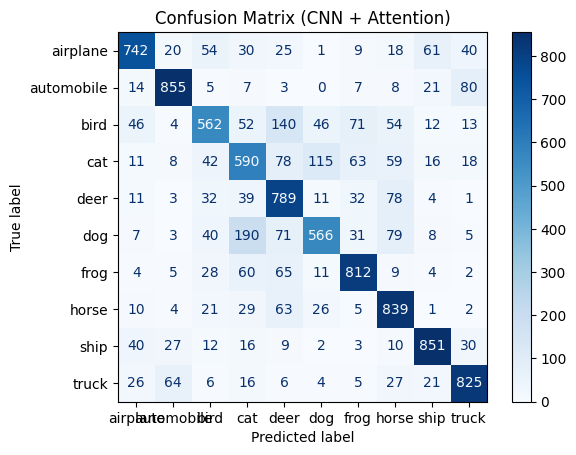

In [ ]:
# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

# CNN with Attention
class NetWithAttention(nn.Module):
    def __init__(self):
        super(NetWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.attn1 = SelfAttention(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.attn2 = SelfAttention(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.attn1(self.conv1(x))))
        x = self.pool(torch.relu(self.attn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model, loss, optimizer
net_attention = NetWithAttention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_attention.parameters(), lr=0.001)

tracker = EmissionsTracker(project_name="cnn_attention")
tracker.start()

# Training loop
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_attention(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

emissions = tracker.stop()
print(f"\033[1mEstimated CO₂ emissions (Attention): {emissions:.4f} kg\033[0m")

# Evaluation
net_attention.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_attention(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\033[1mTest Accuracy (Attention): {accuracy:.2f}%\033[0m")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN + Attention)")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (Attention): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (Attention): {accuracy:.2f}%\033[0m")

Estimated CO₂ emissions (Attention): 0.0376 kg
Test Accuracy (Attention): 74.31%


In [ ]:
model_results.append({
    "Model": "CNN + Attention",
    "Accuracy": accuracy,
    "CO2 (kg)": emissions
})

**CNN + Federated + Attention**

[codecarbon INFO @ 16:01:09] [setup] RAM Tracking...
[codecarbon INFO @ 16:01:09] [setup] CPU Tracking...
[codecarbon WARNING @ 16:01:09] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 16:01:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 16:01:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 16:01:10] [setup] GPU Tracking...
[codecarbon INFO @ 16:01:10] No GPU found.
[codecarbon INFO @ 16:01:10] >>> Tracker's metadata:
[codecarbon INFO @ 16:01:10]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 16:01:10]   Python version: 3.11.12
[codecarbon INFO @ 16:01:10]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 16:01:10]   Available RAM : 12.675 GB
[codecarbon INFO @ 16:01:10]   CPU count: 2
[codecarbon INFO @ 16:01

Federated + Attention Round 1/5
Client 1 training...


[codecarbon INFO @ 16:01:25] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:01:25] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:01:25] 0.000197 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:40] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:01:40] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:01:40] 0.000394 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:01:55] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:01:55] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:01:55] 0.000591 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:02:10] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:02:10] Energy consumed for a

Client 2 training...


[codecarbon INFO @ 16:07:55] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:07:55] Energy consumed for all CPUs : 0.004782 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:07:55] 0.005316 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:10] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:08:10] Energy consumed for all CPUs : 0.004959 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:08:10] 0.005513 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:25] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:08:25] Energy consumed for all CPUs : 0.005136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:08:25] 0.005710 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:08:40] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:08:40] Energy consumed for a

Client 3 training...


[codecarbon INFO @ 16:14:25] Energy consumed for RAM : 0.001049 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:14:25] Energy consumed for all CPUs : 0.009386 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:25] 0.010435 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:40] Energy consumed for RAM : 0.001069 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:14:40] Energy consumed for all CPUs : 0.009563 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:40] 0.010632 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:14:55] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:14:56] Energy consumed for all CPUs : 0.009740 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:56] 0.010829 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:15:10] Energy consumed for RAM : 0.001109 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:15:11] Energy consumed for a

Client 4 training...


[codecarbon INFO @ 16:20:56] Energy consumed for RAM : 0.001564 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:20:56] Energy consumed for all CPUs : 0.013991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:56] 0.015555 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:11] Energy consumed for RAM : 0.001584 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:21:11] Energy consumed for all CPUs : 0.014168 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:11] 0.015752 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:11] 0.003746 g.CO2eq/s mean an estimation of 118.1348218596203 kg.CO2eq/year
[codecarbon INFO @ 16:21:26] Energy consumed for RAM : 0.001604 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:21:26] Energy consumed for all CPUs : 0.014345 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:21:26] 0.015949 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:21:41] Energy consumed for 

Client 5 training...


[codecarbon INFO @ 16:27:26] Energy consumed for RAM : 0.002079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:27:26] Energy consumed for all CPUs : 0.018596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:26] 0.020675 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:41] Energy consumed for RAM : 0.002099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:27:41] Energy consumed for all CPUs : 0.018773 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:41] 0.020872 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:27:56] Energy consumed for RAM : 0.002119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:27:56] Energy consumed for all CPUs : 0.018949 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:56] 0.021068 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:28:11] Energy consumed for RAM : 0.002139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:28:11] Energy consumed for a

Federated + Attention Round 2/5
Client 1 training...


[codecarbon INFO @ 16:33:56] Energy consumed for RAM : 0.002594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:33:56] Energy consumed for all CPUs : 0.023199 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:33:56] 0.025793 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:11] Energy consumed for RAM : 0.002614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:34:11] Energy consumed for all CPUs : 0.023376 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:11] 0.025990 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:26] Energy consumed for RAM : 0.002634 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:34:26] Energy consumed for all CPUs : 0.023553 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:34:26] 0.026187 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:34:41] Energy consumed for RAM : 0.002653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:34:41] Energy consumed for a

Client 2 training...


[codecarbon INFO @ 16:40:26] Energy consumed for RAM : 0.003109 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:40:26] Energy consumed for all CPUs : 0.027804 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:26] 0.030912 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:41] Energy consumed for RAM : 0.003129 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:40:41] Energy consumed for all CPUs : 0.027981 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:41] 0.031109 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:40:56] Energy consumed for RAM : 0.003148 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:40:56] Energy consumed for all CPUs : 0.028158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:40:56] 0.031306 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:11] Energy consumed for RAM : 0.003168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:41:11] Energy consumed for a

Client 3 training...


[codecarbon INFO @ 16:46:56] Energy consumed for RAM : 0.003624 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:46:56] Energy consumed for all CPUs : 0.032408 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:46:56] 0.036031 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:11] Energy consumed for RAM : 0.003643 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:47:11] Energy consumed for all CPUs : 0.032585 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:47:11] 0.036228 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:11] 0.003746 g.CO2eq/s mean an estimation of 118.1416300626218 kg.CO2eq/year
[codecarbon INFO @ 16:47:26] Energy consumed for RAM : 0.003663 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:47:26] Energy consumed for all CPUs : 0.032762 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:47:26] 0.036426 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:47:41] Energy consumed for 

Client 4 training...


[codecarbon INFO @ 16:53:26] Energy consumed for RAM : 0.004138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:53:26] Energy consumed for all CPUs : 0.037012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:53:26] 0.041151 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:41] Energy consumed for RAM : 0.004158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:53:41] Energy consumed for all CPUs : 0.037189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:53:41] 0.041348 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:53:56] Energy consumed for RAM : 0.004178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:53:56] Energy consumed for all CPUs : 0.037367 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:53:56] 0.041545 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:54:11] Energy consumed for RAM : 0.004198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:54:11] Energy consumed for a

Client 5 training...


[codecarbon INFO @ 16:59:57] Energy consumed for RAM : 0.004653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 16:59:57] Energy consumed for all CPUs : 0.041617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:59:57] 0.046270 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:12] Energy consumed for RAM : 0.004673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:00:12] Energy consumed for all CPUs : 0.041794 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:00:12] 0.046467 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:27] Energy consumed for RAM : 0.004693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:00:27] Energy consumed for all CPUs : 0.041971 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:00:27] 0.046664 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:00:42] Energy consumed for RAM : 0.004713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:00:42] Energy consumed for a

Federated + Attention Round 3/5
Client 1 training...


[codecarbon INFO @ 17:06:27] Energy consumed for RAM : 0.005168 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:06:27] Energy consumed for all CPUs : 0.046221 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:06:27] 0.051389 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:42] Energy consumed for RAM : 0.005188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:06:42] Energy consumed for all CPUs : 0.046398 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:06:42] 0.051586 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:06:57] Energy consumed for RAM : 0.005208 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:06:57] Energy consumed for all CPUs : 0.046575 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:06:57] 0.051783 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:07:12] Energy consumed for RAM : 0.005227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:07:12] Energy consumed for a

Client 2 training...


[codecarbon INFO @ 17:12:57] Energy consumed for RAM : 0.005683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:12:57] Energy consumed for all CPUs : 0.050825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:12:57] 0.056507 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:12] Energy consumed for RAM : 0.005703 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:13:12] Energy consumed for all CPUs : 0.051002 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:13:12] 0.056704 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:12] 0.003746 g.CO2eq/s mean an estimation of 118.13990277165914 kg.CO2eq/year
[codecarbon INFO @ 17:13:27] Energy consumed for RAM : 0.005722 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:13:27] Energy consumed for all CPUs : 0.051179 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:13:27] 0.056901 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:13:42] Energy consumed for

Client 3 training...


[codecarbon INFO @ 17:19:27] Energy consumed for RAM : 0.006197 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:19:27] Energy consumed for all CPUs : 0.055429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:27] 0.061626 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:42] Energy consumed for RAM : 0.006217 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:19:42] Energy consumed for all CPUs : 0.055606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:42] 0.061823 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:19:57] Energy consumed for RAM : 0.006237 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:19:57] Energy consumed for all CPUs : 0.055783 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:19:57] 0.062020 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:20:12] Energy consumed for RAM : 0.006257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:20:12] Energy consumed for a

Client 4 training...


[codecarbon INFO @ 17:25:57] Energy consumed for RAM : 0.006712 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:25:57] Energy consumed for all CPUs : 0.060032 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:25:57] 0.066745 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:12] Energy consumed for RAM : 0.006732 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:26:12] Energy consumed for all CPUs : 0.060209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:26:12] 0.066941 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:27] Energy consumed for RAM : 0.006752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:26:27] Energy consumed for all CPUs : 0.060387 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:26:27] 0.067138 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:26:42] Energy consumed for RAM : 0.006772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:26:42] Energy consumed for a

Client 5 training...


[codecarbon INFO @ 17:32:27] Energy consumed for RAM : 0.007227 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:32:27] Energy consumed for all CPUs : 0.064636 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:27] 0.071863 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:42] Energy consumed for RAM : 0.007247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:32:42] Energy consumed for all CPUs : 0.064814 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:42] 0.072060 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:32:57] Energy consumed for RAM : 0.007267 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:32:57] Energy consumed for all CPUs : 0.064991 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:32:57] 0.072257 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:33:12] Energy consumed for RAM : 0.007286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:33:12] Energy consumed for a

Federated + Attention Round 4/5
Client 1 training...


[codecarbon INFO @ 17:38:57] Energy consumed for RAM : 0.007742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:38:57] Energy consumed for all CPUs : 0.069242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:38:57] 0.076984 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:12] Energy consumed for RAM : 0.007762 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:39:12] Energy consumed for all CPUs : 0.069419 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:39:12] 0.077181 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:12] 0.003746 g.CO2eq/s mean an estimation of 118.13376947149443 kg.CO2eq/year
[codecarbon INFO @ 17:39:27] Energy consumed for RAM : 0.007782 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:39:27] Energy consumed for all CPUs : 0.069596 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:39:27] 0.077378 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:39:42] Energy consumed for

Client 2 training...


[codecarbon INFO @ 17:45:28] Energy consumed for RAM : 0.008257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:45:28] Energy consumed for all CPUs : 0.073847 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:45:28] 0.082103 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:43] Energy consumed for RAM : 0.008277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:45:43] Energy consumed for all CPUs : 0.074024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:45:43] 0.082300 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:45:58] Energy consumed for RAM : 0.008296 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:45:58] Energy consumed for all CPUs : 0.074201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:45:58] 0.082497 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:46:13] Energy consumed for RAM : 0.008316 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:46:13] Energy consumed for a

Client 3 training...


[codecarbon INFO @ 17:51:58] Energy consumed for RAM : 0.008772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:51:58] Energy consumed for all CPUs : 0.078451 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:51:58] 0.087222 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:13] Energy consumed for RAM : 0.008791 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:52:13] Energy consumed for all CPUs : 0.078628 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:52:13] 0.087419 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:28] Energy consumed for RAM : 0.008811 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:52:28] Energy consumed for all CPUs : 0.078805 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:52:28] 0.087616 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:52:43] Energy consumed for RAM : 0.008831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:52:43] Energy consumed for a

Client 4 training...


[codecarbon INFO @ 17:58:28] Energy consumed for RAM : 0.009286 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:58:28] Energy consumed for all CPUs : 0.083055 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:58:28] 0.092341 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:58:43] Energy consumed for RAM : 0.009306 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:58:43] Energy consumed for all CPUs : 0.083232 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:58:43] 0.092538 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:58:58] Energy consumed for RAM : 0.009326 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:58:58] Energy consumed for all CPUs : 0.083409 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:58:58] 0.092735 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:59:13] Energy consumed for RAM : 0.009346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 17:59:13] Energy consumed for a

Client 5 training...


[codecarbon INFO @ 18:04:58] Energy consumed for RAM : 0.009801 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:04:58] Energy consumed for all CPUs : 0.087659 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:04:58] 0.097460 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:13] Energy consumed for RAM : 0.009821 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:05:13] Energy consumed for all CPUs : 0.087836 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:05:13] 0.097657 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:13] 0.003746 g.CO2eq/s mean an estimation of 118.1408932719831 kg.CO2eq/year
[codecarbon INFO @ 18:05:28] Energy consumed for RAM : 0.009841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:05:28] Energy consumed for all CPUs : 0.088013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:05:28] 0.097854 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:05:43] Energy consumed for 

Federated + Attention Round 5/5
Client 1 training...


[codecarbon INFO @ 18:11:28] Energy consumed for RAM : 0.010316 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:11:28] Energy consumed for all CPUs : 0.092263 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:11:28] 0.102579 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:43] Energy consumed for RAM : 0.010336 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:11:43] Energy consumed for all CPUs : 0.092440 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:11:43] 0.102776 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:11:58] Energy consumed for RAM : 0.010356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:11:58] Energy consumed for all CPUs : 0.092617 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:11:58] 0.102973 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:12:13] Energy consumed for RAM : 0.010375 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:12:13] Energy consumed for a

Client 2 training...


[codecarbon INFO @ 18:17:58] Energy consumed for RAM : 0.010831 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:17:58] Energy consumed for all CPUs : 0.096867 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:17:58] 0.107698 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:13] Energy consumed for RAM : 0.010851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:18:13] Energy consumed for all CPUs : 0.097044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:18:13] 0.107895 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:28] Energy consumed for RAM : 0.010870 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:18:28] Energy consumed for all CPUs : 0.097221 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:18:28] 0.108092 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:18:43] Energy consumed for RAM : 0.010890 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:18:43] Energy consumed for a

Client 3 training...


[codecarbon INFO @ 18:24:29] Energy consumed for RAM : 0.011346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:24:29] Energy consumed for all CPUs : 0.101472 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:24:29] 0.112818 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:44] Energy consumed for RAM : 0.011365 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:24:44] Energy consumed for all CPUs : 0.101649 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:24:44] 0.113015 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:24:59] Energy consumed for RAM : 0.011385 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:24:59] Energy consumed for all CPUs : 0.101826 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:24:59] 0.113211 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:25:14] Energy consumed for RAM : 0.011405 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:25:14] Energy consumed for a

Client 4 training...


[codecarbon INFO @ 18:30:59] Energy consumed for RAM : 0.011860 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:30:59] Energy consumed for all CPUs : 0.106076 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:30:59] 0.117936 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:14] Energy consumed for RAM : 0.011880 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:31:14] Energy consumed for all CPUs : 0.106253 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:31:14] 0.118133 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:14] 0.003746 g.CO2eq/s mean an estimation of 118.14250068549194 kg.CO2eq/year
[codecarbon INFO @ 18:31:29] Energy consumed for RAM : 0.011900 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:31:29] Energy consumed for all CPUs : 0.106430 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:31:29] 0.118330 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:31:44] Energy consumed for

Client 5 training...


[codecarbon INFO @ 18:37:29] Energy consumed for RAM : 0.012375 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:37:29] Energy consumed for all CPUs : 0.110681 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:37:29] 0.123057 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:37:44] Energy consumed for RAM : 0.012395 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:37:44] Energy consumed for all CPUs : 0.110859 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:37:44] 0.123254 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:37:59] Energy consumed for RAM : 0.012415 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:37:59] Energy consumed for all CPUs : 0.111036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:37:59] 0.123451 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:38:14] Energy consumed for RAM : 0.012435 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:38:14] Energy consumed for a

Estimated CO₂ emissions (Federated + Attention): 0.0365 kg
Test Accuracy (Federated + Attention): 62.41%


<Figure size 1000x800 with 0 Axes>

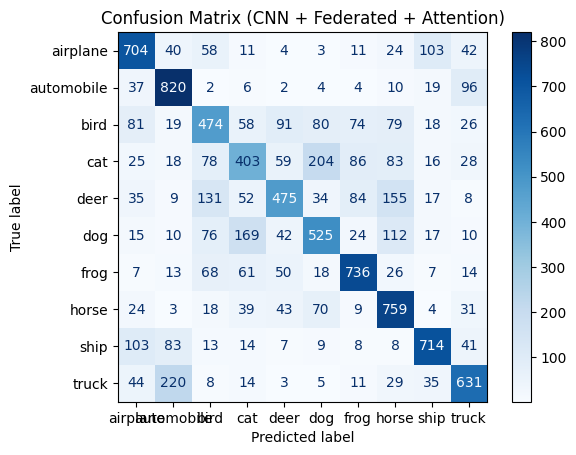

In [ ]:
# Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()
        proj_query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, H * W)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, H * W)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return self.gamma * out + x

# CNN with Attention
class NetWithAttention(nn.Module):
    def __init__(self):
        super(NetWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.attn1 = SelfAttention(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.attn2 = SelfAttention(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.attn1(self.conv1(x))))
        x = self.pool(torch.relu(self.attn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

num_clients = 5
client_datasets = random_split(trainset_augmented, [len(trainset_augmented) // num_clients] * num_clients)
client_loaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in client_datasets]

# Local training function
def train_local_model_attention(model, loader, epochs=1):
    model = copy.deepcopy(model).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict()

# Federated averaging function
def fed_avg(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for key in avg:
        for i in range(1, len(state_dicts)):
            avg[key] += state_dicts[i][key]
        avg[key] /= len(state_dicts)
    return avg

# Initialize global model
global_model = NetWithAttention().to(device)
tracker = EmissionsTracker(project_name="cnn_federated_attention")
tracker.start()

# Federated training loop
for r in range(5):
    print(f"Federated + Attention Round {r+1}/5")
    local_weights = []
    for i, loader in enumerate(client_loaders):
        print(f"Client {i+1} training...")
        weights = train_local_model_attention(global_model, loader)
        local_weights.append(weights)
    global_model.load_state_dict(fed_avg(local_weights))

emissions = tracker.stop()
print(f"\033[1mEstimated CO₂ emissions (Federated + Attention): {emissions:.4f} kg\033[0m")

# Evaluation
global_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = global_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\033[1mTest Accuracy (Federated + Attention): {accuracy:.2f}%\033[0m")

# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN + Federated + Attention)")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (CNN + Federated + Attention): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (CNN + Federated + Attention): {accuracy:.2f}%\033[0m")

Estimated CO₂ emissions (CNN + Federated + Attention): 0.0365 kg
Test Accuracy (CNN + Federated + Attention): 62.41%


In [ ]:
model_results.append({
    "Model": "CNN + Federated + Attention",
    "Accuracy": accuracy,
    "CO2 (kg)": emissions
})

**CNN + Custom Loss**

[codecarbon INFO @ 18:46:27] [setup] RAM Tracking...
[codecarbon INFO @ 18:46:27] [setup] CPU Tracking...
[codecarbon WARNING @ 18:46:27] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 18:46:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:46:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 18:46:28] [setup] GPU Tracking...
[codecarbon INFO @ 18:46:29] No GPU found.
[codecarbon INFO @ 18:46:29] >>> Tracker's metadata:
[codecarbon INFO @ 18:46:29]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:46:29]   Python version: 3.11.12
[codecarbon INFO @ 18:46:29]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 18:46:29]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:46:29]   CPU count: 2
[codecarbon INFO @ 18:46

[Epoch 1, Batch 100] loss: 2.063


[codecarbon INFO @ 18:46:59] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:46:59] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:46:59] 0.000394 kWh of electricity used since the beginning.


[Epoch 1, Batch 200] loss: 1.786


[codecarbon INFO @ 18:47:14] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:47:14] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:47:14] 0.000591 kWh of electricity used since the beginning.


[Epoch 1, Batch 300] loss: 1.728


[codecarbon INFO @ 18:47:29] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:47:29] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:47:29] 0.000788 kWh of electricity used since the beginning.


[Epoch 1, Batch 400] loss: 1.677


[codecarbon INFO @ 18:47:44] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:47:44] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:47:44] 0.000985 kWh of electricity used since the beginning.


[Epoch 1, Batch 500] loss: 1.641


[codecarbon INFO @ 18:47:59] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:47:59] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:47:59] 0.001182 kWh of electricity used since the beginning.


[Epoch 1, Batch 600] loss: 1.612


[codecarbon INFO @ 18:48:14] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:48:14] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:48:14] 0.001378 kWh of electricity used since the beginning.


[Epoch 1, Batch 700] loss: 1.595


[codecarbon INFO @ 18:48:29] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:48:29] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:48:29] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:29] 0.003746 g.CO2eq/s mean an estimation of 118.1350459773793 kg.CO2eq/year
[codecarbon INFO @ 18:48:44] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:48:44] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:48:44] 0.001772 kWh of electricity used since the beginning.


[Epoch 2, Batch 100] loss: 1.534


[codecarbon INFO @ 18:48:59] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:48:59] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:48:59] 0.001969 kWh of electricity used since the beginning.


[Epoch 2, Batch 200] loss: 1.508


[codecarbon INFO @ 18:49:14] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:49:14] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:14] 0.002166 kWh of electricity used since the beginning.


[Epoch 2, Batch 300] loss: 1.515


[codecarbon INFO @ 18:49:29] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:49:29] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:29] 0.002362 kWh of electricity used since the beginning.


[Epoch 2, Batch 400] loss: 1.484


[codecarbon INFO @ 18:49:44] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:49:44] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:44] 0.002559 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:59] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:49:59] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:49:59] 0.002756 kWh of electricity used since the beginning.


[Epoch 2, Batch 500] loss: 1.457


[codecarbon INFO @ 18:50:14] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:50:14] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:14] 0.002953 kWh of electricity used since the beginning.


[Epoch 2, Batch 600] loss: 1.447


[codecarbon INFO @ 18:50:29] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:50:29] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:29] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:29] 0.003745 g.CO2eq/s mean an estimation of 118.11735601725306 kg.CO2eq/year


[Epoch 2, Batch 700] loss: 1.456


[codecarbon INFO @ 18:50:44] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:50:44] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:44] 0.003347 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:59] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:50:59] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:50:59] 0.003544 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:14] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:51:14] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:14] 0.003740 kWh of electricity used since the beginning.


[Epoch 3, Batch 100] loss: 1.400


[codecarbon INFO @ 18:51:29] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:51:29] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:29] 0.003937 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:44] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:51:44] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:44] 0.004134 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:59] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:51:59] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:51:59] 0.004331 kWh of electricity used since the beginning.


[Epoch 3, Batch 200] loss: 1.406


[codecarbon INFO @ 18:52:14] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:52:14] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:14] 0.004528 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:29] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:52:29] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:29] 0.004725 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:29] 0.003746 g.CO2eq/s mean an estimation of 118.14582586642835 kg.CO2eq/year
[codecarbon INFO @ 18:52:44] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:52:44] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:52:44] 0.004922 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:59] Energy consumed for

[Epoch 3, Batch 300] loss: 1.371


[codecarbon INFO @ 18:53:29] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:53:29] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:29] 0.005512 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:44] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:53:44] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:44] 0.005709 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:59] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:53:59] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:53:59] 0.005906 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:14] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:54:14] Energy consumed for a

[Epoch 3, Batch 400] loss: 1.368


[codecarbon INFO @ 18:54:44] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:54:44] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:44] 0.006497 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:59] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:54:59] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:54:59] 0.006693 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:14] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:55:14] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:14] 0.006890 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:29] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:55:29] Energy consumed for a

[Epoch 3, Batch 500] loss: 1.384


[codecarbon INFO @ 18:55:59] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:55:59] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:55:59] 0.007481 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:14] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:56:14] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:14] 0.007678 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:29] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:56:29] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:56:29] 0.007875 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:29] 0.003746 g.CO2eq/s mean an estimation of 118.14839887468736 kg.CO2eq/year
[codecarbon INFO @ 18:56:44] Energy consumed for

[Epoch 3, Batch 600] loss: 1.369


[codecarbon INFO @ 18:57:14] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:57:14] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:14] 0.008465 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:29] Energy consumed for RAM : 0.000871 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:57:29] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:29] 0.008662 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:44] Energy consumed for RAM : 0.000891 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:57:44] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:57:44] 0.008859 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:59] Energy consumed for RAM : 0.000911 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:57:59] Energy consumed for a

[Epoch 3, Batch 700] loss: 1.354


[codecarbon INFO @ 18:58:44] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:58:44] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:44] 0.009646 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:58:59] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:58:59] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:58:59] 0.009843 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:14] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:59:14] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:59:14] 0.010040 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:29] Energy consumed for RAM : 0.001030 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 18:59:29] Energy consumed for a

[Epoch 4, Batch 100] loss: 1.346


[codecarbon INFO @ 19:01:29] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:01:29] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:29] 0.011812 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:44] Energy consumed for RAM : 0.001208 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:01:44] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:44] 0.012009 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:59] Energy consumed for RAM : 0.001228 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:01:59] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:01:59] 0.012206 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:02:14] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:02:14] Energy consumed for a

[Epoch 4, Batch 200] loss: 1.351


[codecarbon INFO @ 19:02:44] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:02:44] Energy consumed for all CPUs : 0.011510 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:44] 0.012797 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:02:59] Energy consumed for RAM : 0.001307 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:02:59] Energy consumed for all CPUs : 0.011687 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:02:59] 0.012993 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:14] Energy consumed for RAM : 0.001327 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:03:14] Energy consumed for all CPUs : 0.011864 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:14] 0.013190 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:29] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:03:29] Energy consumed for a

[Epoch 4, Batch 300] loss: 1.314


[codecarbon INFO @ 19:03:59] Energy consumed for RAM : 0.001386 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:03:59] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:03:59] 0.013781 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:14] Energy consumed for RAM : 0.001406 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:04:14] Energy consumed for all CPUs : 0.012572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:14] 0.013978 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:29] Energy consumed for RAM : 0.001426 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:04:29] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:04:29] 0.014175 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:29] 0.003746 g.CO2eq/s mean an estimation of 118.1432741128164 kg.CO2eq/year
[codecarbon INFO @ 19:04:44] Energy consumed for 

[Epoch 4, Batch 400] loss: 1.299


[codecarbon INFO @ 19:05:14] Energy consumed for RAM : 0.001485 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:05:14] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:14] 0.014765 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:29] Energy consumed for RAM : 0.001505 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:05:29] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:29] 0.014962 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:44] Energy consumed for RAM : 0.001525 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:05:44] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:05:44] 0.015159 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:59] Energy consumed for RAM : 0.001544 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:05:59] Energy consumed for a

[Epoch 4, Batch 500] loss: 1.315


[codecarbon INFO @ 19:06:29] Energy consumed for RAM : 0.001584 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:06:29] Energy consumed for all CPUs : 0.014166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:29] 0.015750 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:29] 0.003746 g.CO2eq/s mean an estimation of 118.14888754809692 kg.CO2eq/year
[codecarbon INFO @ 19:06:44] Energy consumed for RAM : 0.001604 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:06:44] Energy consumed for all CPUs : 0.014343 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:44] 0.015947 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:59] Energy consumed for RAM : 0.001624 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:06:59] Energy consumed for all CPUs : 0.014520 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:06:59] 0.016143 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:14] Energy consumed for

[Epoch 4, Batch 600] loss: 1.310


[codecarbon INFO @ 19:07:44] Energy consumed for RAM : 0.001683 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:07:44] Energy consumed for all CPUs : 0.015051 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:44] 0.016734 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:59] Energy consumed for RAM : 0.001703 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:07:59] Energy consumed for all CPUs : 0.015228 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:07:59] 0.016931 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:14] Energy consumed for RAM : 0.001723 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:08:14] Energy consumed for all CPUs : 0.015405 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:14] 0.017128 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:29] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:08:29] Energy consumed for a

[Epoch 4, Batch 700] loss: 1.299


[codecarbon INFO @ 19:08:59] Energy consumed for RAM : 0.001782 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:08:59] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:08:59] 0.017718 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:14] Energy consumed for RAM : 0.001802 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:09:14] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:14] 0.017915 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:29] Energy consumed for RAM : 0.001822 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:09:29] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:09:29] 0.018112 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:09:44] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:09:44] Energy consumed for a

[Epoch 5, Batch 100] loss: 1.295


[codecarbon INFO @ 19:11:29] Energy consumed for RAM : 0.001980 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:11:29] Energy consumed for all CPUs : 0.017707 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:29] 0.019687 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:44] Energy consumed for RAM : 0.002000 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:11:44] Energy consumed for all CPUs : 0.017884 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:44] 0.019884 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:59] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:11:59] Energy consumed for all CPUs : 0.018061 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:11:59] 0.020080 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:14] Energy consumed for RAM : 0.002039 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:12:14] Energy consumed for a

[Epoch 5, Batch 200] loss: 1.281


[codecarbon INFO @ 19:12:59] Energy consumed for RAM : 0.002099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:12:59] Energy consumed for all CPUs : 0.018769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:12:59] 0.020868 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:14] Energy consumed for RAM : 0.002118 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:13:14] Energy consumed for all CPUs : 0.018946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:14] 0.021065 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:29] Energy consumed for RAM : 0.002138 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:13:29] Energy consumed for all CPUs : 0.019123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:13:29] 0.021262 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:44] Energy consumed for RAM : 0.002158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:13:44] Energy consumed for a

[Epoch 5, Batch 300] loss: 1.271


[codecarbon INFO @ 19:14:29] Energy consumed for RAM : 0.002217 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:14:29] Energy consumed for all CPUs : 0.019832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:29] 0.022049 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:29] 0.003746 g.CO2eq/s mean an estimation of 118.13635099538426 kg.CO2eq/year
[codecarbon INFO @ 19:14:44] Energy consumed for RAM : 0.002237 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:14:44] Energy consumed for all CPUs : 0.020009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:44] 0.022246 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:59] Energy consumed for RAM : 0.002257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:14:59] Energy consumed for all CPUs : 0.020186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:14:59] 0.022443 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:14] Energy consumed for

[Epoch 5, Batch 400] loss: 1.269


[codecarbon INFO @ 19:16:14] Energy consumed for RAM : 0.002356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:16:14] Energy consumed for all CPUs : 0.021071 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:14] 0.023427 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:29] Energy consumed for RAM : 0.002376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:16:29] Energy consumed for all CPUs : 0.021248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:29] 0.023624 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:29] 0.003746 g.CO2eq/s mean an estimation of 118.1328006009143 kg.CO2eq/year
[codecarbon INFO @ 19:16:44] Energy consumed for RAM : 0.002396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:16:44] Energy consumed for all CPUs : 0.021425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:16:44] 0.023821 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:59] Energy consumed for 

[Epoch 5, Batch 500] loss: 1.235


[codecarbon INFO @ 19:17:44] Energy consumed for RAM : 0.002475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:17:44] Energy consumed for all CPUs : 0.022134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:44] 0.024608 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:59] Energy consumed for RAM : 0.002495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:17:59] Energy consumed for all CPUs : 0.022311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:17:59] 0.024805 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:14] Energy consumed for RAM : 0.002514 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:18:14] Energy consumed for all CPUs : 0.022488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:18:14] 0.025002 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:29] Energy consumed for RAM : 0.002534 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:18:29] Energy consumed for a

[Epoch 5, Batch 600] loss: 1.258


[codecarbon INFO @ 19:19:29] Energy consumed for RAM : 0.002613 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:19:29] Energy consumed for all CPUs : 0.023373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:29] 0.025987 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:44] Energy consumed for RAM : 0.002633 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:19:44] Energy consumed for all CPUs : 0.023550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:44] 0.026183 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:59] Energy consumed for RAM : 0.002653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:19:59] Energy consumed for all CPUs : 0.023727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:19:59] 0.026380 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:14] Energy consumed for RAM : 0.002673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:20:14] Energy consumed for a

[Epoch 5, Batch 700] loss: 1.246


[codecarbon INFO @ 19:21:14] Energy consumed for RAM : 0.002752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:21:14] Energy consumed for all CPUs : 0.024613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:14] 0.027365 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:29] Energy consumed for RAM : 0.002772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:21:29] Energy consumed for all CPUs : 0.024790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:29] 0.027562 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:44] Energy consumed for RAM : 0.002792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:21:44] Energy consumed for all CPUs : 0.024967 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:21:44] 0.027759 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:59] Energy consumed for RAM : 0.002811 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:21:59] Energy consumed for a

Estimated CO₂ emissions (Custom Loss): 0.0081 kg
Test Accuracy (Custom Loss): 68.73%


<Figure size 1000x800 with 0 Axes>

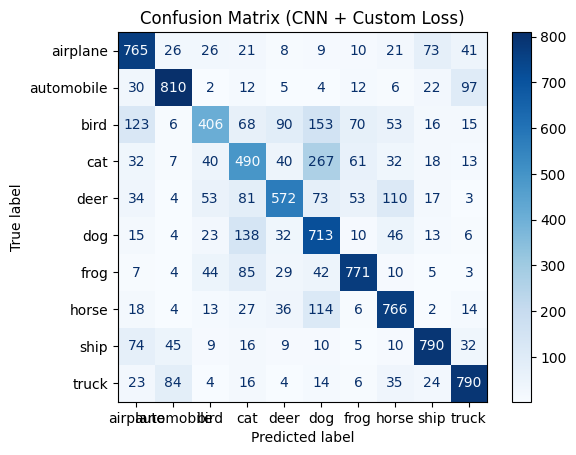

In [ ]:
# Reuse the CNN model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model
net_custom = Net().to(device)
optimizer = optim.Adam(net_custom.parameters(), lr=0.001)
base_criterion = nn.CrossEntropyLoss()
lambda_energy = 0.001  # Weight for energy penalty

tracker = EmissionsTracker(project_name="cnn_custom_loss")
tracker.start()

# Training loop with custom loss
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net_custom(inputs)
        ce_loss = base_criterion(outputs, labels)

        # Custom energy penalty (L2 norm of all weights)
        energy_penalty = sum((p**2).sum() for p in net_custom.parameters())
        total_loss = ce_loss + lambda_energy * energy_penalty

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

emissions = tracker.stop()
print(f"\033[1mEstimated CO₂ emissions (Custom Loss): {emissions:.4f} kg\033[0m")

# Evaluation
net_custom.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_custom(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\033[1mTest Accuracy (Custom Loss): {accuracy:.2f}%\033[0m")

# Confusion Matrix

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN + Custom Loss)")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (Custom Loss): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (Custom Loss): {accuracy:.2f}%\033[0m")

Estimated CO₂ emissions (Custom Loss): 0.0081 kg
Test Accuracy (Custom Loss): 68.73%


In [ ]:
model_results.append({
    "Model": "CNN + Custom Loss",
    "Accuracy": accuracy,
    "CO2 (kg)": emissions
})

**CNN + Federated + Custom Loss**

[codecarbon INFO @ 19:25:38] [setup] RAM Tracking...
[codecarbon INFO @ 19:25:38] [setup] CPU Tracking...
[codecarbon WARNING @ 19:25:38] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 19:25:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:25:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:25:39] [setup] GPU Tracking...
[codecarbon INFO @ 19:25:39] No GPU found.
[codecarbon INFO @ 19:25:39] >>> Tracker's metadata:
[codecarbon INFO @ 19:25:39]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 19:25:39]   Python version: 3.11.12
[codecarbon INFO @ 19:25:39]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 19:25:39]   Available RAM : 12.675 GB
[codecarbon INFO @ 19:25:39]   CPU count: 2
[codecarbon INFO @ 19:25

Federated Round 1/5 (Custom Loss)
Client 1 training...


[codecarbon INFO @ 19:25:54] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:25:54] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:25:54] 0.000197 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 19:26:09] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:26:09] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:09] 0.000394 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:24] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:26:24] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:24] 0.000591 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 19:26:39] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:26:39] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:39] 0.000788 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:54] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:26:54] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:26:54] 0.000984 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 19:27:09] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:27:09] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:09] 0.001181 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 19:27:24] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:27:24] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:24] 0.001378 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:39] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:27:39] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:39] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:39] 0.003746 g.CO2eq/s mean an estimation of 118.14031027547601 kg.CO2eq/year


Federated Round 2/5 (Custom Loss)
Client 1 training...


[codecarbon INFO @ 19:27:54] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:27:54] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:27:54] 0.001772 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:09] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:28:09] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:09] 0.001969 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 19:28:24] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:28:24] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:24] 0.002165 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:39] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:28:39] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:39] 0.002363 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 19:28:54] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:28:54] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:28:54] 0.002559 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 19:29:09] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:29:09] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:09] 0.002756 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:24] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:29:24] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:24] 0.002953 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 19:29:39] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:29:39] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:39] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:29:39] 0.003746 g.CO2eq/s mean an estimation of 118.13875173202754 kg.CO2eq/year
[codecarbon INFO @ 19:29:54] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:29:54] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:29:54] 0.003347 kWh of electricity used since the beginning.


Federated Round 3/5 (Custom Loss)
Client 1 training...


[codecarbon INFO @ 19:30:09] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:30:09] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:09] 0.003544 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 19:30:24] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:30:24] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:24] 0.003741 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:39] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:30:39] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:39] 0.003938 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 19:30:54] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:30:54] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:30:54] 0.004135 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:09] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:31:09] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:09] 0.004332 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 19:31:24] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:31:24] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:24] 0.004529 kWh of electricity used since the beginning.


Client 5 training...


[codecarbon INFO @ 19:31:39] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:31:39] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:39] 0.004725 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:39] 0.003746 g.CO2eq/s mean an estimation of 118.13223533993596 kg.CO2eq/year
[codecarbon INFO @ 19:31:54] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:31:54] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:31:54] 0.004922 kWh of electricity used since the beginning.


Federated Round 4/5 (Custom Loss)
Client 1 training...


[codecarbon INFO @ 19:32:09] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:32:09] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:09] 0.005119 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:32:24] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:32:24] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:24] 0.005316 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 19:32:39] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:32:39] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:39] 0.005513 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 19:32:54] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:32:54] Energy consumed for all CPUs : 0.005136 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:32:54] 0.005710 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:09] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:33:09] Energy consumed for all CPUs : 0.005313 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:09] 0.005907 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 19:33:24] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:33:24] Energy consumed for all CPUs : 0.005490 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:24] 0.006103 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:39] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:33:39] Energy consumed for all CPUs : 0.005667 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:39] 0.006300 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:39] 0.003746 g.CO2eq/s mean an estimation of 118.1404317281699 kg.CO2eq/year


Client 5 training...


[codecarbon INFO @ 19:33:54] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:33:54] Energy consumed for all CPUs : 0.005844 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:33:54] 0.006497 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:09] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:34:09] Energy consumed for all CPUs : 0.006021 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:09] 0.006694 kWh of electricity used since the beginning.


Federated Round 5/5 (Custom Loss)
Client 1 training...


[codecarbon INFO @ 19:34:24] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:34:24] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:24] 0.006891 kWh of electricity used since the beginning.


Client 2 training...


[codecarbon INFO @ 19:34:39] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:34:39] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:39] 0.007088 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:54] Energy consumed for RAM : 0.000733 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:34:54] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:34:54] 0.007284 kWh of electricity used since the beginning.


Client 3 training...


[codecarbon INFO @ 19:35:09] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:35:09] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:09] 0.007481 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:24] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:35:24] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:24] 0.007678 kWh of electricity used since the beginning.


Client 4 training...


[codecarbon INFO @ 19:35:39] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:35:39] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:39] 0.007875 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:39] 0.003746 g.CO2eq/s mean an estimation of 118.12608429638901 kg.CO2eq/year


Client 5 training...


[codecarbon INFO @ 19:35:54] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:35:54] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:35:54] 0.008072 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:09] Energy consumed for RAM : 0.000832 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:36:09] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:09] 0.008269 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:16] Energy consumed for RAM : 0.000841 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 19:36:16] Energy consumed for all CPUs : 0.007519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:36:16] 0.008359 kWh of electricity used since the beginning.


Estimated CO₂ emissions (Federated + Custom Loss): 0.0024 kg
Test Accuracy (Federated + Custom Loss): 56.93%


<Figure size 1000x800 with 0 Axes>

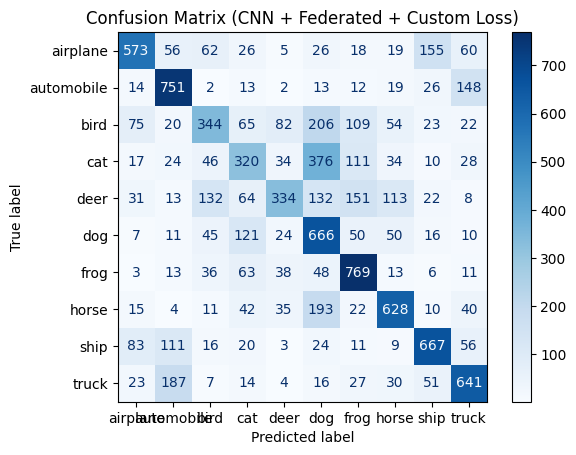

In [ ]:
# Reuse CNN model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Federated split (reusing trainset_augmented)

num_clients = 5
client_datasets = random_split(trainset_augmented, [len(trainset_augmented) // num_clients] * num_clients)
client_loaders = [DataLoader(ds, batch_size=64, shuffle=True) for ds in client_datasets]

# Local training function with custom loss
def train_local_model_custom(model, loader, epochs=1, lam=0.001):
    model = copy.deepcopy(model).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    base_criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            ce_loss = base_criterion(outputs, labels)

            # Custom energy penalty
            energy_penalty = sum((p**2).sum() for p in model.parameters())
            total_loss = ce_loss + lam * energy_penalty

            total_loss.backward()
            optimizer.step()

    return model.state_dict()

# Federated averaging
def fed_avg(state_dicts):
    avg = copy.deepcopy(state_dicts[0])
    for key in avg:
        for i in range(1, len(state_dicts)):
            avg[key] += state_dicts[i][key]
        avg[key] /= len(state_dicts)
    return avg

# Federated training
global_model = Net().to(device)
tracker = EmissionsTracker(project_name="cnn_federated_custom_loss")
tracker.start()

for r in range(5):
    print(f"Federated Round {r+1}/5 (Custom Loss)")
    local_weights = []
    for i, loader in enumerate(client_loaders):
        print(f"Client {i+1} training...")
        weights = train_local_model_custom(global_model, loader, epochs=1, lam=0.001)
        local_weights.append(weights)
    global_model.load_state_dict(fed_avg(local_weights))

emissions = tracker.stop()
print(f"\033[1mEstimated CO₂ emissions (Federated + Custom Loss): {emissions:.4f} kg\033[0m")

# Evaluation
global_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = global_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\033[1mTest Accuracy (Federated + Custom Loss): {accuracy:.2f}%\033[0m")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN + Federated + Custom Loss)")
plt.show()


In [ ]:
print(f"\033[1mEstimated CO₂ emissions (CNN + Federated + Custom Loss): {emissions:.4f} kg\033[0m")
print(f"\033[1mTest Accuracy (CNN + Federated + Custom Loss): {accuracy:.2f}%\033[0m")

Estimated CO₂ emissions (CNN + Federated + Custom Loss): 0.0024 kg
Test Accuracy (CNN + Federated + Custom Loss): 56.93%


In [ ]:
model_results.append({
    "Model": "CNN + Federated + Custom Loss",
    "Accuracy": accuracy,
    "CO2 (kg)": emissions
})

# **Model Comparison**

In [ ]:
print("Model Results:")
for result in model_results:
    print(result)

Model Results:
{'Model': 'CNN', 'Accuracy': 72.22, 'CO2 (kg)': 0.0024609131619106627}
{'Model': 'CNN + Federated', 'Accuracy': 61.44, 'CO2 (kg)': 0.002327591949526718}
{'Model': 'CNN + Attention', 'Accuracy': 74.31, 'CO2 (kg)': 0.037604349575713014}
{'Model': 'CNN + Federated + Attention', 'Accuracy': 62.41, 'CO2 (kg)': 0.03653980409063701}
{'Model': 'CNN + Custom Loss', 'Accuracy': 68.73, 'CO2 (kg)': 0.00813947073478131}
{'Model': 'CNN + Federated + Custom Loss', 'Accuracy': 56.93, 'CO2 (kg)': 0.0023866153855257467}


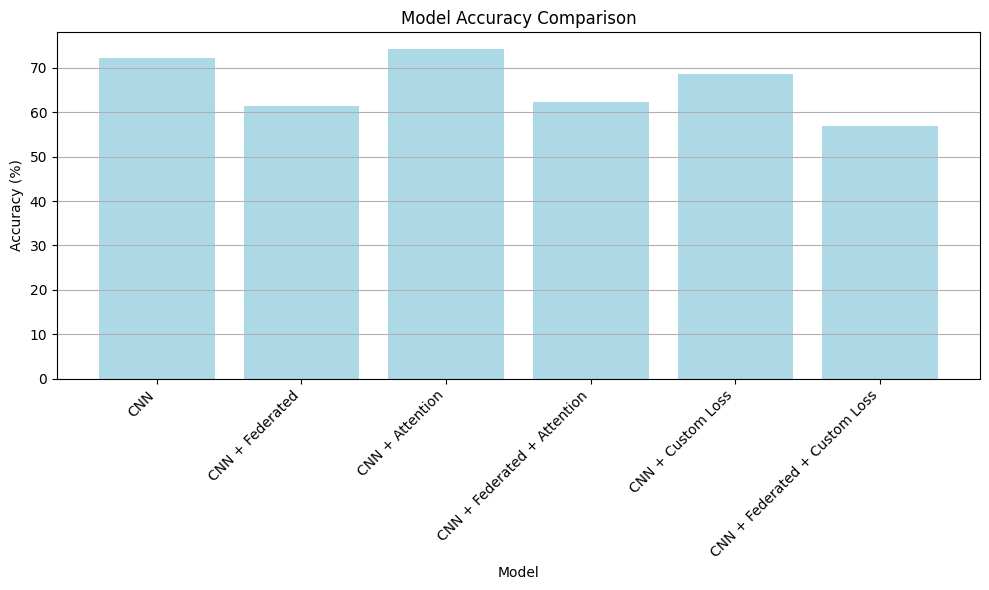

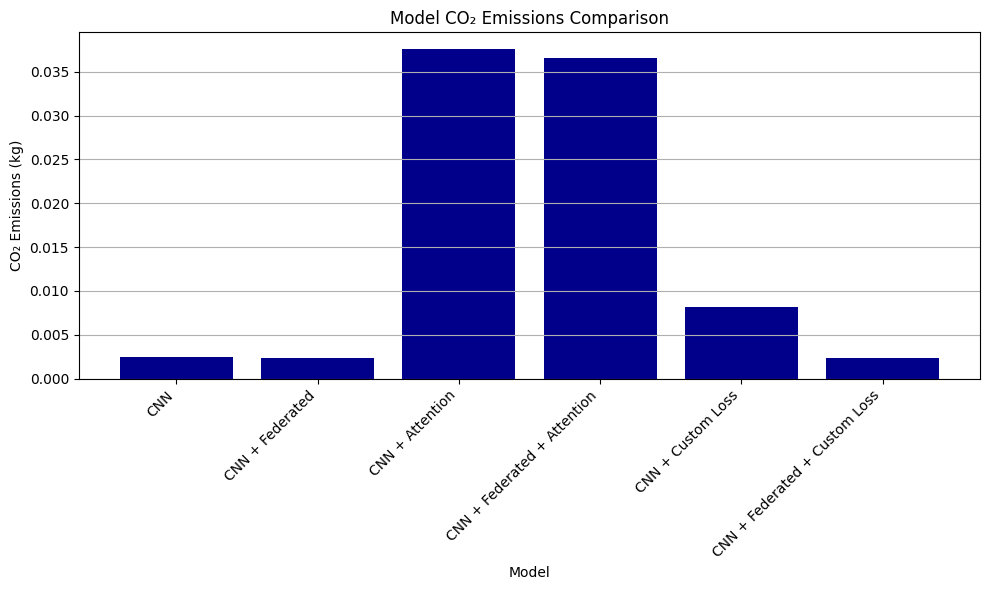


 Model Performance Summary:


,Model,Accuracy,CO2 (kg)
0,CNN,72.22,0.002
1,CNN + Federated,61.44,0.002
2,CNN + Attention,74.31,0.038
3,CNN + Federated + Attention,62.41,0.037
4,CNN + Custom Loss,68.73,0.008
5,CNN + Federated + Custom Loss,56.93,0.002


In [ ]:
if 'model_results' in globals():
    df_results = pd.DataFrame(model_results)
else:
    print("No model results found. Please make sure you've stored results in 'model_results' list.")

# Plot Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(df_results["Model"], df_results["Accuracy"], color='lightblue')
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot CO2 Emissions Comparison
plt.figure(figsize=(10, 6))
plt.bar(df_results["Model"], df_results["CO2 (kg)"], color='darkblue')
plt.xlabel("Model")
plt.ylabel("CO₂ Emissions (kg)")
plt.title("Model CO₂ Emissions Comparison")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Show model performance summary table
print("\n Model Performance Summary:")
from IPython.display import display
display(df_results.round(3))